In [1]:
from dataset import SiTDataset
from tqdm import tqdm
import os
os.environ['PYTHONPATH'] = '/env/python:/content/SiT'
import torch
from torchvision.utils import save_image
from transport import create_transport, Sampler
from diffusers.models import AutoencoderKL
from download import find_model
from models import SiT_S_2, SiT_B_8
import lpips
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity, mean_squared_error

/home/d/dziri/venvs/jlab/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_pose_radius(pose):
    translation_vector = pose[:3, 3] #shape [1, 32, 32]
    radius = torch.norm(translation_vector)
    
    return radius

def calculate_psnr(image, prediction):
    mse = np.mean((image - prediction) ** 2)
    if mse == 0:
        return float('inf')

    max_pixel = 255.0  # Assuming 8-bit images; change if your pixel values differ
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def evaluate_prediction(ground_truth, prediction):
    ground_truth = ground_truth.detach().cpu().numpy()
    prediction = prediction.detach().cpu().numpy()

    ground_truth = ground_truth.transpose(1, 2, 0)
    prediction = prediction.transpose(1, 2, 0)

    if ground_truth.max() <= 1.0:
        ground_truth = ground_truth * 255.0
    if prediction.max() <= 1.0:
        prediction = prediction * 255.0

    ground_truth = np.clip(ground_truth, 0, 255).astype(np.float32)
    prediction = np.clip(prediction, 0, 255).astype(np.float32)
    
    psnr = calculate_psnr(ground_truth, prediction)
    mse = mean_squared_error(ground_truth.flatten(), prediction.flatten())
    
    return round(float(psnr)), round(float(mse))

In [3]:
image_size = "128"
vae_model = "stabilityai/sd-vae-ft-ema"
latent_size = int(image_size) // 8

model = SiT_B_8(input_size=latent_size, num_classes=1).to('cuda')
state_dict = find_model("results/300_epochs/0060000.pt")                # Print the actual tensor (can be large!)
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to('cuda')


/home/d/dziri/big/SiT/SiT/download.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_name, map_location=lambda storage, loc: storage)


In [4]:
#seed = 1 #@param {type:"number"}
#torch.manual_seed(seed)

num_sampling_steps = 250

cfg_scale = 4

class_labels = [0]
sampler_type = "ODE"

transport = create_transport()
sampler = Sampler(transport)

In [5]:
# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler"
    diffusion_form = "linear"
    
    """This tells how strong the noise is"""
    diffusion_norm = 1
    
    """How the final denoised latent should be calculated"""
    last_step = "Mean"
    last_step_size = 0.4
    
    """Final function at the end that does everything:
    """
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form, 
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size, 
        num_steps=num_sampling_steps,
    )
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5"

    atol = 1e-6
    rtol = 1e-3
    
    sample_fn = sampler.sample_ode(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps
    )

In [6]:
from torchvision import transforms
from torch.utils.data import DataLoader

vae = AutoencoderKL.from_pretrained(vae_model).to("cuda")

device = 'cuda'

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
])

dataset = SiTDataset("data/chair_data/test", transform=transform)

eval_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

ys = torch.zeros(1, dtype=torch.long, device="cuda")

In [7]:
from torchvision.utils import save_image
import torch
from tqdm import tqdm

max_pairs = 10                    # how many GT/pred rows to keep
gt_pool, pred_pool = [], []       # hold first 10 pairs for final sheet

total_psnr = total_mse = total_ssim = 0.0
plot_data = []
i = 0
with torch.inference_mode(): 
    for image, pose, _ in tqdm(eval_loader, "Evaluating model..."):
        image = image.to("cuda")
        pose  = pose.to("cuda")
        radius = round(get_pose_radius(pose).item(), 2)
    
        # ─── inference ────────────────────────────────────────────────────────────
        n = ys.size(0)
        y = torch.IntTensor([0]).to(device)
        z = torch.cat([pose, pose], 0)
        y_null = torch.tensor([1] * n, device="cuda")
        y = torch.cat([y, y_null], 0)
        model_kwargs = dict(y=y, cfg_scale=cfg_scale)
    
        samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[-1]
        samples = vae.decode(samples / 0.18215).sample
        samples = samples[0]                  # (C,H,W)
        image   = image[0]
    
        # ─── similarity metrics ──────────────────────────────────────────────────
        psnr, mse = evaluate_prediction(image, samples)
    
        plot_data.append([radius / 10, psnr, mse])
        total_psnr += psnr
        total_mse  += mse
    
        # ─── store first 10 GT / prediction pairs ────────────────────────────────
        if len(gt_pool) < max_pairs:
            gt_pool.append(image.cpu())
            pred_pool.append(samples.cpu())    

        if i == 30:
            break
        else:
            i += 1

# ─── save the sheet with 10 rows × 2 columns (GT | PRED) ─────────────────────
if gt_pool:
    sheet_images = torch.stack(
        [im for pair in zip(gt_pool, pred_pool) for im in pair]
    )  # shape: (20, C, H, W)

    save_image(
        sheet_images,
        "gt_vs_pred_first10.png",
        nrow=2,                         # 2 columns: GT left, prediction right
        padding=2,
        normalize=True,
        value_range=(-1, 1)
    )

# ─── finish metrics ──────────────────────────────────────────────────────────
num_batches = len(eval_loader)
total_psnr /= num_batches
total_mse  /= num_batches

print("PSNR:", total_psnr)
print("MSE: ", total_mse)


Evaluating model...:   1%|▏                   | 30/3000 [00:13<22:12,  2.23it/s]

PSNR: 0.17166666666666666
MSE:  16.944333333333333


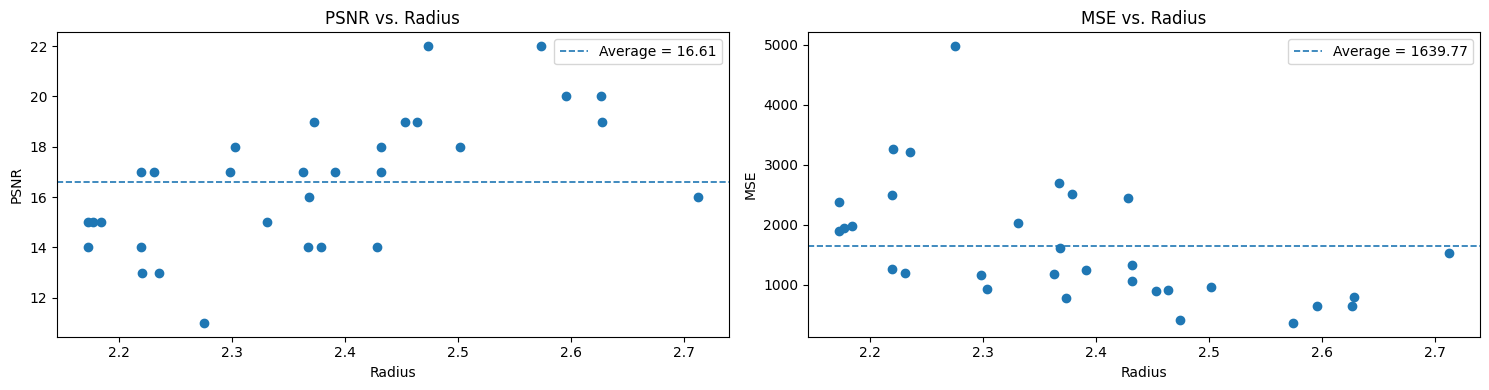

In [8]:
import numpy as np
import matplotlib.pyplot as plt

data   = np.array(plot_data, dtype=float)
data   = data[data[:, 0].argsort()]

radius = data[:, 0]
psnr   = data[:, 1]
mse    = data[:, 2]

fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharex=True)

def add_panel(ax, y, y_label, title):
    ax.plot(radius, y, marker='o', linestyle='none')      # ← changed line
    ax.axhline(y.mean(), ls='--', lw=1.2,
               label=f'Average = {y.mean():.2f}')
    ax.set_xlabel('Radius')
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()

add_panel(axes[0], psnr, 'PSNR', 'PSNR vs. Radius')
add_panel(axes[1], mse,  'MSE',  'MSE vs. Radius')

plt.tight_layout()

fig.savefig("radius_metrics.png", dpi=300, bbox_inches="tight")

plt.show()


# Test invertibility of SiT

In [3]:
image_size = "128"
vae_model = "stabilityai/sd-vae-ft-ema"
latent_size = int(image_size) // 8

model = SiT_B_8(input_size=latent_size, num_classes=1).to('cuda')
state_dict = find_model("results/300_epochs/0060000.pt")                # Print the actual tensor (can be large!)
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to('cuda')

/home/d/dziri/big/SiT/SiT/download.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_name, map_location=lambda storage, loc: storage)


In [4]:
#seed = 1 #@param {type:"number"}
#torch.manual_seed(seed)

num_sampling_steps = 250

cfg_scale = 4

class_labels = [0]
sampler_type = "ODE"

transport = create_transport()
sampler = Sampler(transport)

In [5]:
# Sample images:
if sampler_type == "SDE":
    SDE_sampling_method = "Euler"
    diffusion_form = "linear"
    
    """This tells how strong the noise is"""
    diffusion_norm = 1
    
    """How the final denoised latent should be calculated"""
    last_step = "Mean"
    last_step_size = 0.4
    
    """Final function at the end that does everything:
    """
    sample_fn = sampler.sample_sde(
        sampling_method=SDE_sampling_method,
        diffusion_form=diffusion_form, 
        diffusion_norm=diffusion_norm,
        last_step_size=last_step_size, 
        num_steps=num_sampling_steps,
        reverse=True
    )
elif sampler_type == "ODE":
    # default to Adaptive Solver
    ODE_sampling_method = "dopri5"

    atol = 1e-6
    rtol = 1e-3
    
    sample_fn = sampler.sample_ode_backwards(
        sampling_method=ODE_sampling_method,
        atol=atol,
        rtol=rtol,
        num_steps=num_sampling_steps,
        reverse=False
    )

In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader

vae = AutoencoderKL.from_pretrained(vae_model).to("cuda")

device = 'cuda'

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
])

dataset = SiTDataset("data/chair_data/test", transform=transform)

eval_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

def extract_pose(pose):
    pass

ys = torch.zeros(1, dtype=torch.long, device="cuda")

In [19]:
#Iterate over testset loader, get image, pose
total_psnr = 0
total_mse = 0
total_ssim = 0
plot_data = []

def reverse_pose(pose):
    flat16 = pose[0, 0, :16]          # shape (16,)

    orig_4x4 = flat16.view(4, 4) 

    return orig_4x4

for image, pose, noise in tqdm(eval_loader, "Evaluating model..."):
    ogimage = image
    image = image.to("cuda")
    posterior = vae.encode(image)[0]
    image = posterior.sample()
    image = image * 0.18215

    pose = pose.to("cuda")
    radius = get_pose_radius(pose)
    radius = round(radius.item(), 2)

    noise = noise.to("cuda")[0]
    
    n = ys.size(0)
    y = torch.IntTensor([0]).to(device)
    z = torch.cat([image, image], 0)
    y_null = torch.tensor([1] * n, device="cuda")

    y = torch.cat([y, y_null], 0)
    model_kwargs = dict(y=y, cfg_scale=cfg_scale)
    
    #Use pose to synthesize a new image using SiT
    samples = sample_fn(z, model.forward_with_cfg, **model_kwargs)[-1]
    samples = samples[0][0]
    samples = samples - noise

    samples = samples
    image = image[0]

    save_image(samples, 
               f"sample_1.png", 
               nrow=int(1),
               normalize=True, value_range=(-1, 1))
    save_image(ogimage, 
           f"og_1.png", 
           nrow=int(1),
           normalize=True, value_range=(-1, 1))

    denoised_pose = samples - noise

    print(denoised_pose.shape)

    psnr, mse, ssim = evaluate_prediction(image, samples)

    plot_data.append([radius, psnr, mse, ssim])
    total_psnr += psnr
    total_mse += mse
    total_ssim += ssim

    break

total_psnr /= eval_loader.__len__()
total_mse /= eval_loader.__len__()
total_ssim /= eval_loader.__len__()

print("PSNR:", total_psnr)
print("MSE:", total_mse)
print("SSIM:", total_ssim)

Evaluating model...:   0%|                             | 0/3000 [00:02<?, ?it/s]

torch.Size([4, 16, 16])


ValueError: not enough values to unpack (expected 3, got 2)